# Physics 4C: Constitutive Law P12 without prior

In [45]:
from constitutive_laws_generator import LinearElasticConstitutiveLaw, NeoHookeanConstitutiveLaw
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from sympy import *
from kan import *
from kan.compiler import kanpiler

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)
torch.set_default_dtype(torch.float64)

N = 1000
sigma = 0.5 # previously sigma = 0.2

F = torch.eye(3,3)[None,:,:].expand(N,3,3) + (torch.rand(N,3,3)*2-1)*sigma
det = torch.det(F)
F *= (det > 0)[:,None,None]
F_flatten = F.reshape(N, -1)

linear = LinearElasticConstitutiveLaw(young_modulus=1.0, poisson_ratio=0.2)
P_l = linear(F)
P11_l = P_l[:,[0],[0]]
P12_l = P_l[:,[0],[1]]

neo = NeoHookeanConstitutiveLaw(young_modulus=1.0, poisson_ratio=0.2)
P_n = neo(F)
P11_n = P_n[:,[0],[0]]
P12_n = P_n[:,[0],[1]]

# P11
# linear: P11 = 2 * mu * (F11 - 1) + lambda * (F11 + F22 + F33 - 3)
# neohookean: P11 = mu * (F11^2 + F21^2 + F31^2 - 1) + lambda * log(|F|)

# P12
# linear: P12 = mu * (F12 + F21)
# neohookean: P12 = mu * (F12 * F11 + F22 * F21 + F32 * F31)
input_vars = F11, F12, F13, F21, F22, F23, F31, F32, F33 = symbols('F11 F12 F13 F21 F22 F23 F31 F32 F33')
dataset = create_dataset_from_data(F_flatten, P12_n)

In [46]:
# train from scratch without prior knowledge
model2 = KAN(width=[9,[5,5],1], base_fun='identity', sparse_init=True, seed=2)
model2.fit(dataset, steps=100, lamb=1e-5, lamb_coef=1.0);

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.73e-04 | test_loss: 8.13e-04 | reg: 1.06e+01 | : 100%|█| 100/100 [01:49<00:00,  1.09

saving model version 0.1


checkpoint directory created: ./model
saving model version 0.0


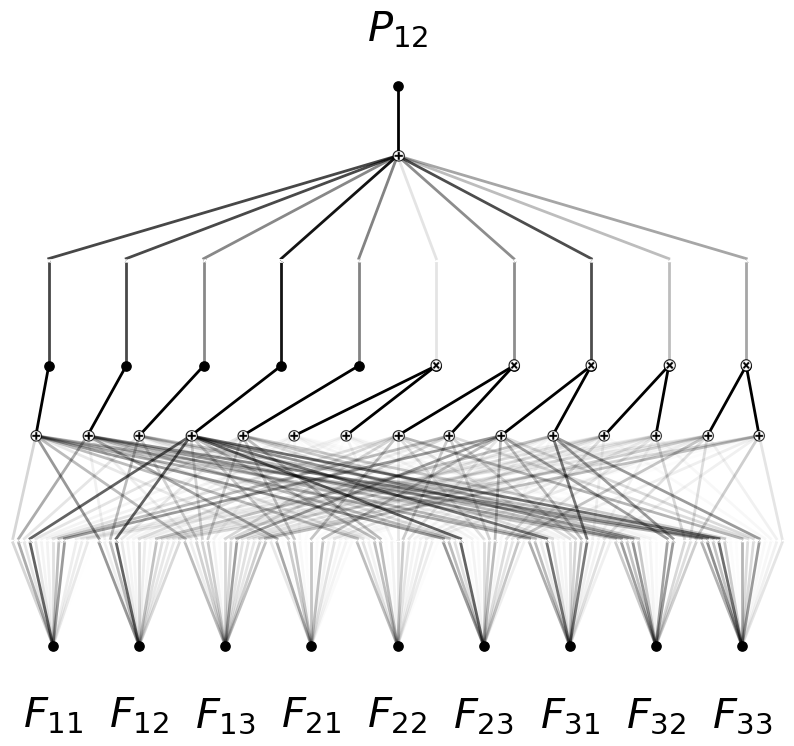

In [54]:
model = KAN(width=[9,[5,5],1], base_fun='identity', sparse_init=True, seed=2)
model.get_act(F_flatten)
model.plot(in_vars=input_vars, scale=1.0, varscale=0.75, out_vars=[r'$P_{12}$'], out_vars_offset=0.08)

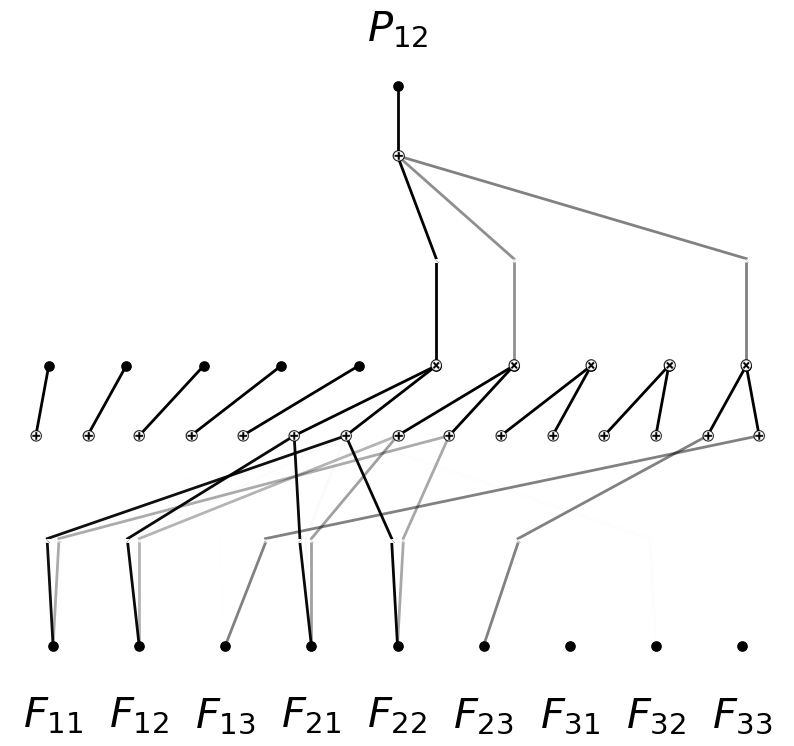

In [49]:
model2.plot(in_vars=input_vars, scale=1.0, varscale=0.75, out_vars=[r'$P_{12}$'], out_vars_offset=0.08)

In [50]:
model2 = model2.prune()

saving model version 0.2


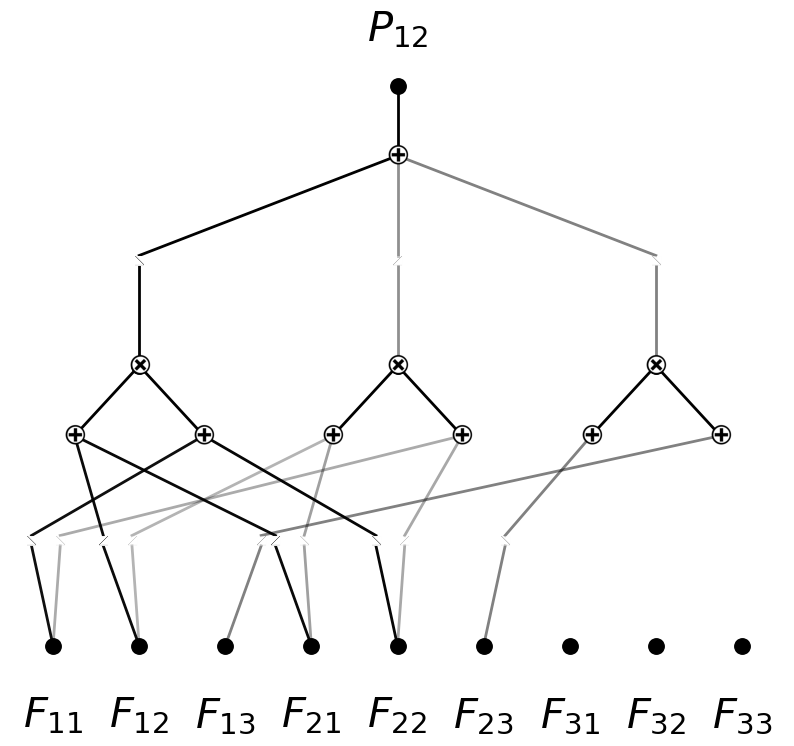

In [52]:
model2.plot(in_vars=input_vars, scale=1.0, varscale=0.75, out_vars=[r'$P_{12}$'], out_vars_offset=0.08)

In [30]:
model2.fit(dataset, steps=100);

| train_loss: 6.76e-08 | test_loss: 5.88e-07 | reg: 9.48e+00 | : 100%|█| 100/100 [00:37<00:00,  2.66

saving model version 0.3


In [31]:
model2.auto_symbolic()

fixing (0,0,0) with 0
fixing (0,0,1) with x, r2=0.9999999669805822, c=1
fixing (0,0,2) with 0
fixing (0,0,3) with x, r2=0.9999998698486439, c=1
fixing (0,0,4) with 0
fixing (0,0,5) with 0
fixing (0,1,0) with x, r2=0.999999977929924, c=1
fixing (0,1,1) with 0
fixing (0,1,2) with x, r2=0.9999998228247213, c=1
fixing (0,1,3) with 0
fixing (0,1,4) with 0
fixing (0,1,5) with 0
fixing (0,2,0) with 0
fixing (0,2,1) with 0
fixing (0,2,2) with 0
fixing (0,2,3) with 0
fixing (0,2,4) with 0
fixing (0,2,5) with x, r2=0.9999999679466729, c=1
fixing (0,3,0) with x, r2=0.9999999818694265, c=1
fixing (0,3,1) with 0
fixing (0,3,2) with x, r2=0.9999999051111973, c=1
fixing (0,3,3) with 0
fixing (0,3,4) with 0
fixing (0,3,5) with 0
fixing (0,4,0) with 0
fixing (0,4,1) with x, r2=0.9999999820945513, c=1
fixing (0,4,2) with 0
fixing (0,4,3) with x, r2=0.9999998917416573, c=1
fixing (0,4,4) with 0
fixing (0,4,5) with 0
fixing (0,5,0) with 0
fixing (0,5,1) with 0
fixing (0,5,2) with 0
fixing (0,5,3) with 0
f

In [35]:
model2.unfix_symbolic(1,1,0)
model2.fix_symbolic(1,1,0,'x')
model2.unfix_symbolic(1,2,0)
model2.fix_symbolic(1,2,0,'x')

saving model version 0.5
Best value at boundary.
r2 is 0.9985630103092588
saving model version 0.6
saving model version 0.7
Best value at boundary.
r2 is 0.9997571945982016
saving model version 0.8


tensor(0.9998)

In [36]:
model2.fit(dataset, steps=100);

| train_loss: 6.49e-09 | test_loss: 6.78e-09 | reg: 0.00e+00 | : 100%|█| 100/100 [00:09<00:00, 11.10

saving model version 0.9


In [44]:
from kan.utils import ex_round
ex_round(expand(ex_round(ex_round(model2.symbolic_formula(var=input_vars)[0][0], 8), 5)), 2)

0.42*F11*F21 + 0.42*F12*F22 + 0.42*F13*F23